<a href="https://colab.research.google.com/github/kennethgoodman/Columbia-E4579/blob/main/image_generation_pipelines/dalle_mini_Inference_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DALL·E mini - Inference pipeline

*Generate images from a text prompt*

<img src="https://github.com/borisdayma/dalle-mini/blob/main/img/logo.png?raw=true" width="200">

This notebook illustrates [DALL·E mini](https://github.com/borisdayma/dalle-mini) inference pipeline.

Just want to play? Use directly [the app](https://www.craiyon.com/).

For more understanding of the model, refer to [the report](https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-mini--Vmlldzo4NjIxODA).

Forked from https://colab.research.google.com/github/borisdayma/dalle-mini/blob/main/tools/inference/inference_pipeline.ipynb#scrollTo=SDjEx9JxR3v8

## 🛠️ Installation and set-up

In [1]:
# Install required libraries
!pip install -q dalle-mini
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

     |████████████████████████████████| 235 kB 7.3 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 4.7 MB 78.5 MB/s 
     |████████████████████████████████| 197 kB 94.5 MB/s 
     |████████████████████████████████| 180 kB 59.1 MB/s 
     |████████████████████████████████| 1.8 MB 71.8 MB/s 
     |████████████████████████████████| 1.0 MB 33.7 MB/s 
     |████████████████████████████████| 217 kB 75.5 MB/s 
     |████████████████████████████████| 145 kB 71.7 MB/s 
     |████████████████████████████████| 51 kB 7.2 MB/s 
     |████████████████████████████████| 76 kB 6.3 MB/s 
     |████████████████████████████████| 6.6 MB 81.8 MB/s 
     |████████████████████████████████| 101 kB 13.6 MB/s 
     |████████████████████████████████| 157 kB 88.9 MB/s 
     |████████████████████████████████| 181 kB 72.5 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 157 kB 79.4 MB/s 
     |█████████████████

We load required models:
* DALL·E mini for text to encoded images
* VQGAN for decoding images
* CLIP for scoring predictions

In [2]:
# Model references

# dalle-mega
DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:latest"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None

# if the notebook crashes too often you can use dalle-mini instead by uncommenting below line
# DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

In [3]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

1

In [4]:
# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)

# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Downloading large artifact mega-1-fp16:latest, 4938.53MB. 7 files... Done. 0:1:29.2
Some of the weights of DalleBart were initialized in float16 precision from the model checkpoint at /tmp/tmp66cpfr7m:
[('lm_head', 'kernel'), ('model', 'decoder', 'embed_positions', 'embedding'), ('model', 'decoder', 'embed_tokens', 'embedding'), ('model', 'decoder', 'final_ln', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'scale'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'k_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'out_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'q_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'v_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBart

Model parameters are replicated on each device for faster inference.

In [5]:
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

Model functions are compiled and parallelized to take advantage of multiple devices.

In [6]:
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

Keys are passed to the model on each device to generate unique inference per device.

In [7]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

## 🖍 Text Prompt

Our model requires processing prompts.

In [8]:
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

wandb: Downloading large artifact mega-1-fp16:latest, 4938.53MB. 7 files... Done. 0:0:34.4


Downloading:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

## 🎨 Generate images

We generate images using dalle-mini model and decode them with the VQGAN.

In [9]:
# number of predictions per prompt
n_predictions = 6

# We can customize generation parameters (see https://huggingface.co/blog/how-to-generate)
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

In [10]:
# CLIP model
CLIP_REPO = "openai/clip-vit-base-patch32"
CLIP_COMMIT_ID = None

# Load CLIP
clip, clip_params = FlaxCLIPModel.from_pretrained(
    CLIP_REPO, revision=CLIP_COMMIT_ID, dtype=jnp.float16, _do_init=False
)
clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
clip_params = replicate(clip_params)

# score images
@partial(jax.pmap, axis_name="batch")
def p_clip(inputs, params):
    logits = clip(params=params, **inputs).logits_per_image
    return logits

In [11]:
#@markdown Enable saving outputs to Google Drive to save your creations at AI/models
save_outputs_to_google_drive = True #@param {type:"boolean"}

if save_outputs_to_google_drive:
    from google.colab import drive
    try:
      drive.mount('/content/gdrive')
    except:
      save_outputs_to_google_drive = False

outputs_path = "/content/gdrive/MyDrive/AI/DalleMini/samples" if save_outputs_to_google_drive else "/content/outputs"
!mkdir -p $outputs_path
print(f"Outputs will be saved to {outputs_path}")
import os
os.makedirs(outputs_path, exist_ok=True)


Mounted at /content/gdrive
Outputs will be saved to /content/gdrive/MyDrive/AI/DalleMini/samples


In [23]:
!pip install open_clip_torch
!pip install transformers
!pip install open_clip_torch
!pip install autokeras
!pip install tensorflow

from open_clip import tokenizer
import open_clip
import torch

def load_safety_model(clip_model):
    """load the safety model"""
    import autokeras as ak  # pylint: disable=import-outside-toplevel
    from tensorflow.keras.models import load_model  # pylint: disable=import-outside-toplevel
    from os.path import expanduser  # pylint: disable=import-outside-toplevel

    home = expanduser("~")

    cache_folder = home + "/.cache/clip_retrieval/" + clip_model.replace("/", "_")
    if clip_model == "ViT-L/14":
        model_dir = cache_folder + "/clip_autokeras_binary_nsfw"
        dim = 768
    elif clip_model == "ViT-B/32":
        model_dir = cache_folder + "/clip_autokeras_nsfw_b32"
        dim = 512
    else:
        raise ValueError("Unknown clip model")
    if not os.path.exists(model_dir):
        os.makedirs(cache_folder, exist_ok=True)

        from urllib.request import urlretrieve  # pylint: disable=import-outside-toplevel

        path_to_zip_file = cache_folder + "/clip_autokeras_binary_nsfw.zip"
        if clip_model == "ViT-L/14":
            url_model = "https://raw.githubusercontent.com/LAION-AI/CLIP-based-NSFW-Detector/main/clip_autokeras_binary_nsfw.zip"
        elif clip_model == "ViT-B/32":
            url_model = (
                "https://raw.githubusercontent.com/LAION-AI/CLIP-based-NSFW-Detector/main/clip_autokeras_nsfw_b32.zip"
            )
        else:
            raise ValueError("Unknown model {}".format(clip_model))
        urlretrieve(url_model, path_to_zip_file)
        import zipfile  # pylint: disable=import-outside-toplevel

        with zipfile.ZipFile(path_to_zip_file, "r") as zip_ref:
            zip_ref.extractall(cache_folder)

    loaded_model = load_model(model_dir, custom_objects=ak.CUSTOM_OBJECTS)
    loaded_model.predict(np.random.rand(10 ** 3, dim).astype("float32"), batch_size=10 ** 3)

    return loaded_model

def is_safe(safety_model, embeddings, threshold=0.5):
    """find unsafe embeddings"""
    nsfw_values = safety_model.predict(embeddings, batch_size=embeddings.shape[0])
    x = np.array([e[0] for e in nsfw_values])
    return True if x <= threshold else False

#NSFW CLIP Filter
safety_model = load_safety_model("ViT-B/32")
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')

def is_img_safe(image):
  img = preprocess(image).unsqueeze(0)
  with torch.no_grad():
    image_features = clip_model.encode_image(img)
  image_features /= image_features.norm(dim=-1, keepdim=True)
  query = image_features.cpu().detach().numpy().astype("float32")
  return is_safe(safety_model, query)

def filter_unsafe_images(images):
  return list(filter(is_img_safe, images))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange
from flax.training.common_utils import shard

def get_encode_images(tokenized_prompt, subkey):
  return p_generate(
      tokenized_prompt,
      shard_prng_key(subkey),
      params,
      gen_top_k,
      gen_top_p,
      temperature,
      cond_scale,
  )

def remove_bos(encoded_images):
  return encoded_images.sequences[..., 1:]

def decode_images(encoded_images):
  images = []
  decoded_images = p_decode(encoded_images, vqgan_params)
  decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
  for decoded_img in decoded_images:
      img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
      images.append(img)
  return images

def save_images(images, prompt):
  for img in images:
    base_count = len(os.listdir(outputs_path))
    path = os.path.join(outputs_path, f'{prompt.replace(" ", "-")}.{base_count}.png')
    img.save(path)

def saving_images_with_scores(images_with_scores, prompt, top_k=2):
  for i, (img, score) in enumerate(images_with_scores[:top_k]):
    base_count = len(os.listdir(outputs_path))
    path = os.path.join(outputs_path, f'{prompt.replace(" ", "-")}.{i}.{score}.png')
    img.save(path)

def display_images(images):
  for img in images:
    display(img)
    print()

def display_images_with_scores(images_with_scores):
  for (img, score) in images_with_scores:
    display(img)
    print(f"Score: {score:.2f}\n")

def get_tokenized_prompt(prompt):
  tokenized_prompt = processor(prompt)
  return replicate(tokenized_prompt)

def fix_prompt(prompt):
  return prompt + ". portrait, detail face"

def get_images(key, prompts):
  images = []
  prompts = list(map(fix_prompt, prompts))
  tokenized_prompt = get_tokenized_prompt(prompts)
  for i in trange(max(n_predictions // jax.device_count(), 1)):
      # get a new key
      key, subkey = jax.random.split(key)
      # generate images and remove BOS
      encoded_images = remove_bos(get_encode_images(tokenized_prompt, subkey))
      # decode images
      images.extend(decode_images(encoded_images))
  return images


def get_logits(images):
  # get clip scores
  clip_inputs = clip_processor(
      text=prompts * jax.device_count(),
      images=images,
      return_tensors="np",
      padding="max_length",
      max_length=77,
      truncation=True,
  ).data
  logits = p_clip(shard(clip_inputs), clip_params)
  return logits      


def rank_images(images, prompts):
  logits = get_logits(images)
  prompts_to_images_with_score = {}
  p = len(prompts)
  logits = np.asarray([logits[:, i::p, i] for i in range(p)]).squeeze()
  for i, prompt in enumerate(prompts):
      prompts_to_images_with_score[prompt] = []
      to_argsort = logits[i] if p > 1 else logits
      for idx in to_argsort.argsort()[::-1]:
          new_image = images[idx * p + i]
          score = jnp.asarray(to_argsort[idx], dtype=jnp.float32)
          prompts_to_images_with_score[prompt].append((new_image, score))
  return prompts_to_images_with_score



We will generate promps from Reddit titles

In [14]:
import requests
import time

def should_filter_in(title):
  return 'NSFW' not in title and len(title) > 50

def edit_title(title):
  return title.replace('(OC)', '').replace('[OC]', '').replace('i made a', '').replace('[dp]', '').strip()

def get_titles(data):
  titles = [child['data']['title'].lower() for child in data]
  filtered_titles = filter(should_filter_in, titles)
  mapped_titles = map(edit_title, filtered_titles)
  return set(mapped_titles)


headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

def get_top_titles_from_subreddit(subreddit, total_limit=1000, t='all'):
  after = ''
  r = requests.get(f'https://www.reddit.com/r/{subreddit}/top.json?limit=100&t={t}', headers=headers)
  x = r.json()
  titles = get_titles(x['data']['children'])
  while len(titles) < total_limit and x['data']['after'] is not None:
    r = requests.get(f"https://www.reddit.com/r/{subreddit}/top.json?limit=100&after={x['data']['after']}&t={t}", headers=headers)
    x = r.json()
    titles |= get_titles(x['data']['children'])
    time.sleep(2)
  return titles

subreddits = ['pics', 'MadeMeSmile', 'Damnthatsinteresting', 'worldnews', 'Confessions', 'AccidentalArt', 'scifi', 'SimplePrompts']
titles = set()
for subreddit in subreddits:
  titles |= get_top_titles_from_subreddit(subreddit, total_limit=200)

In [28]:
import random
random.sample(list(titles), 5)

['housekeepers and janitors need praise as unsung but very much important',
 'i wander the streets of toronto at night, looking for cinematic moments. this is what i found...',
 "the skill and illusion required for this mime's balloon performance",
 'what started as an accidental text turned into an annual tradition!',
 '"did you love her?" "no. but i made her a promise."']

In [24]:
import matplotlib.pyplot as plt
plt.hist(list(map(len, titles)))
plt.show() 

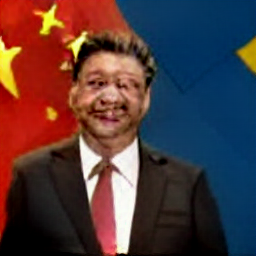

In [32]:
image

Displaying and saving: [dp] "what others called a rebellious phase, i call the sudden realisation i don't deserve to be treated like garbage."


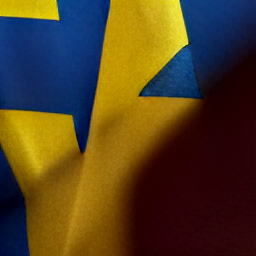

Score: 19.23



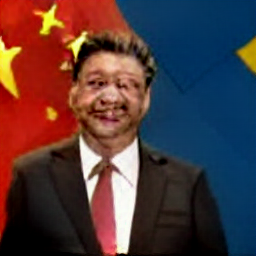

Score: 18.97



Score: 16.46



Score: 15.48



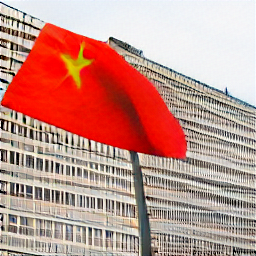

Score: 14.62



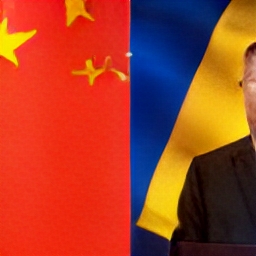

Score: 14.05

Displaying and saving: to not flunk out of college, i changed my grades and thousands of others' as well.


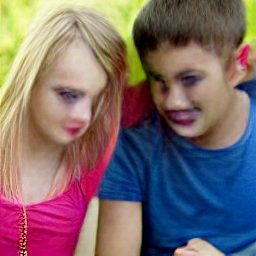

Score: 22.27



Score: 21.89



Score: 21.50



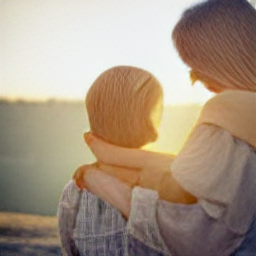

Score: 20.79



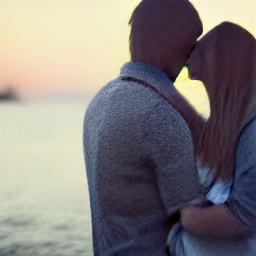

Score: 20.40



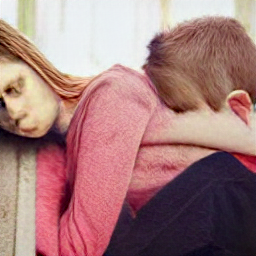

Score: 20.21

Displaying and saving: 5 years ago i promised my sister i would bring a llama to her wedding


Score: 15.22



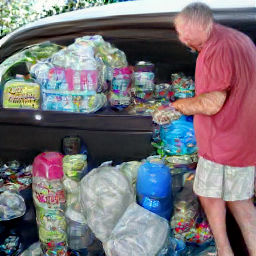

Score: 13.27



Score: 13.05



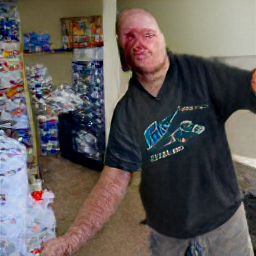

Score: 12.67



Score: 12.52



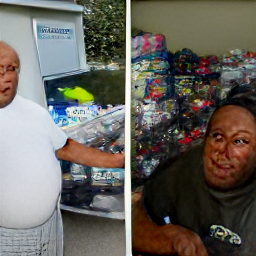

Score: 10.75

Displaying and saving: under elevated subway tracks in brooklyn - an ap photographer took the photo.


Score: 18.75



Score: 17.91



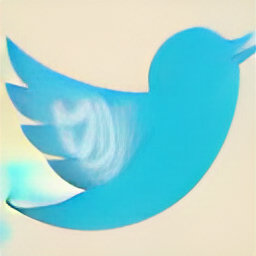

Score: 16.59



Score: 16.28



Score: 16.19



Score: 15.55

Displaying and saving: you refresh the page. and refresh it again. and again. and again. hoping to see the change you want.


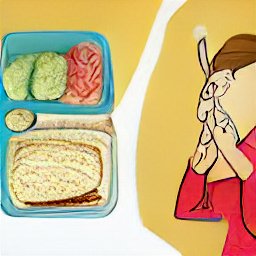

Score: 19.69



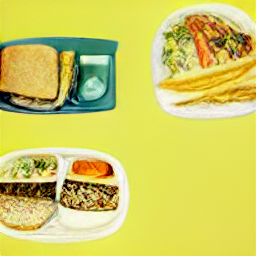

Score: 19.63



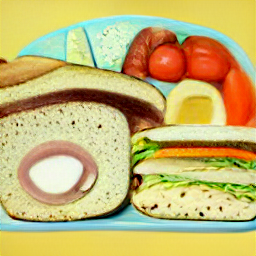

Score: 19.62



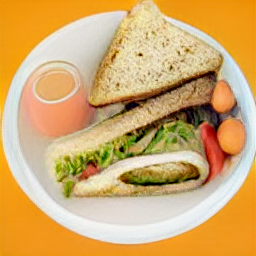

Score: 19.43



Score: 18.70



Score: 16.67

Displaying and saving: revealed: trump’s election consultants filmed saying they use bribes and sex workers to entrap politicians


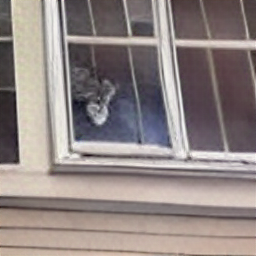

Score: 18.48



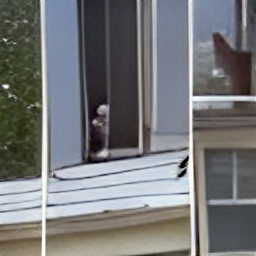

Score: 17.91



Score: 17.85



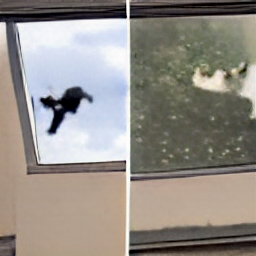

Score: 16.99



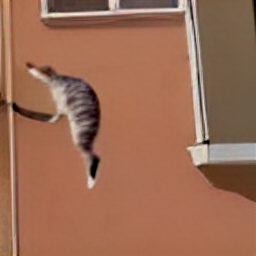

Score: 16.91



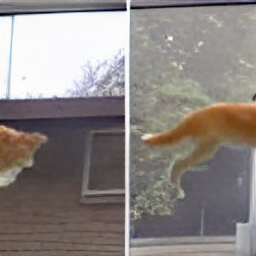

Score: 15.92

Displaying and saving: brazilian spokesperson tests positive for covid-19 after he meets with trump and pence at mar-a-lago


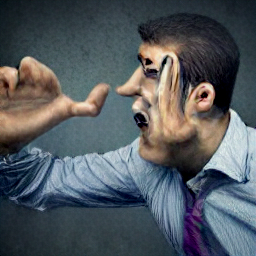

Score: 20.29



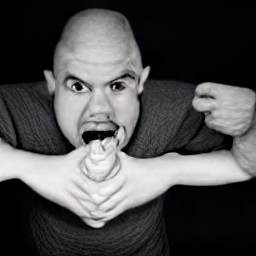

Score: 19.43



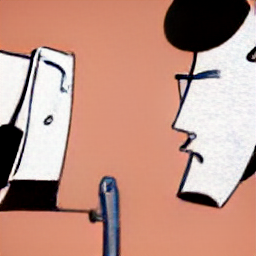

Score: 19.20



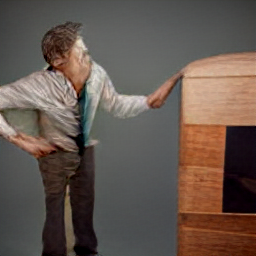

Score: 18.90



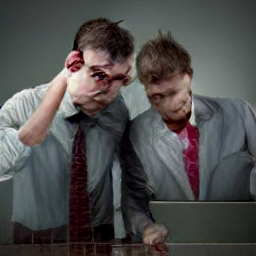

Score: 18.26



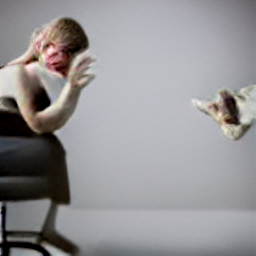

Score: 17.96

Displaying and saving: this man cries after meeting his hero: dwayne "the rock" johnson, when dwayne johnson and jimmy fallon wore mascot versions of themselves to surprise fans at universal studios.


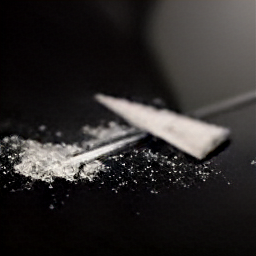

Score: 13.11



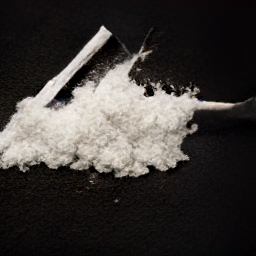

Score: 12.32



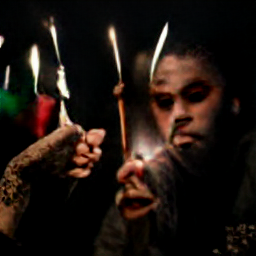

Score: 11.85



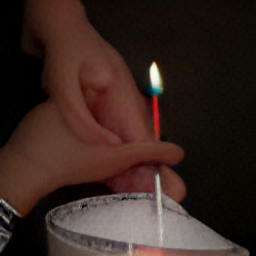

Score: 9.20



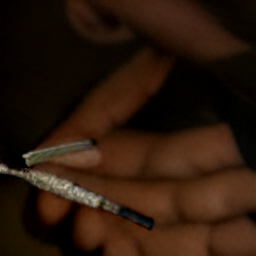

Score: 8.72



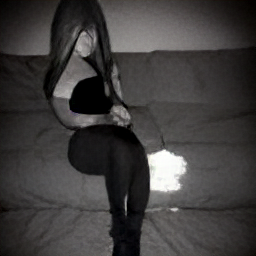

Score: 7.31

Displaying and saving: these are the buttons from a ww2 raf uniform. when you put them together, they make a mini-compass, for use if you get shot down behind enemy lines.


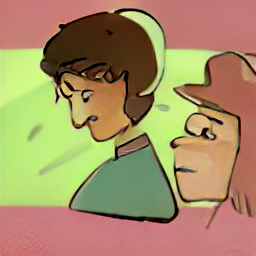

Score: 15.04



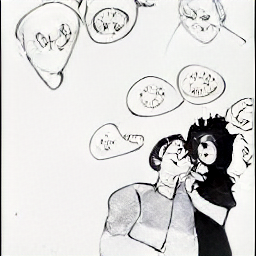

Score: 14.23



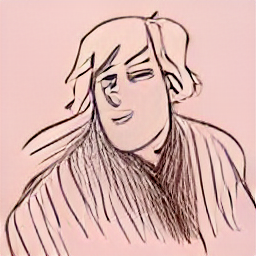

Score: 13.68



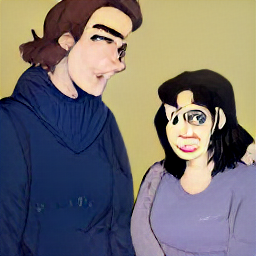

Score: 11.60



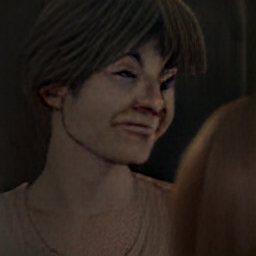

Score: 8.91



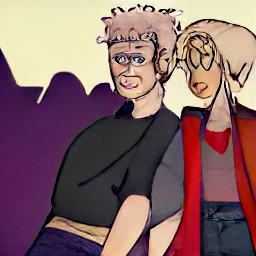

Score: 8.48

Displaying and saving: in south korea, the solar panels in the middle of the highway have a bicycle path underneath..cyclists are protected from the sun, isolated from traffic, and the country can produce clean energy.


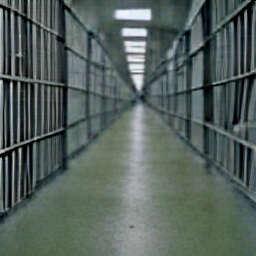

Score: 12.10



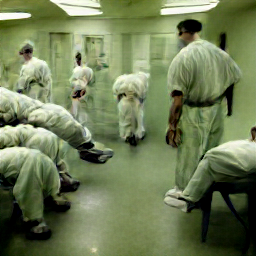

Score: 9.58



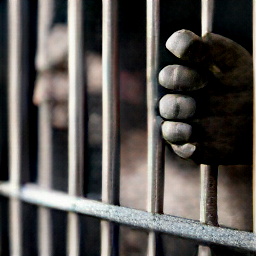

Score: 7.86



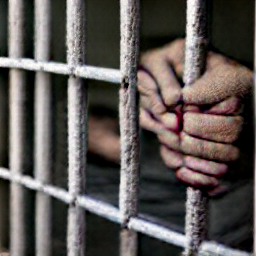

Score: 7.37



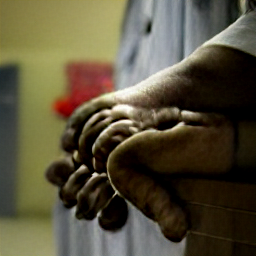

Score: 7.20



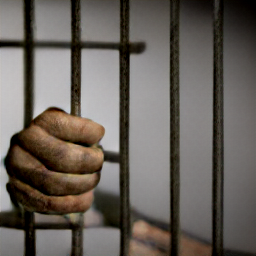

Score: 6.73



In [38]:
# prompts = random.sample(list(titles), 10)

# print(f"Prompts: {prompts}\n")
# # generate images
# seed = random.randint(0, 2**32 - 1)
# key = jax.random.PRNGKey(seed)
# images = get_images(key, prompts)
safe_images = filter_unsafe_images(images)
ranked_images = rank_images(safe_images, prompts)
for prompt in prompts:
  print(f"Displaying and saving: {prompt}")
  display_images_with_scores(ranked_images[prompt])
  saving_images_with_scores(ranked_images[prompt], prompt)

## 🪄 Optional: Save your Generated Images as W&B Tables

W&B Tables is an interactive 2D grid with support to rich media logging. Use this to save the generated images on W&B dashboard and share with the world.

In [ ]:
import wandb

# Initialize a W&B run.
project = 'dalle-mini-tables-colab'
run = wandb.init(project=project)

# Initialize an empty W&B Tables.
columns = ["captions"] + [f"image_{i+1}" for i in range(n_predictions)]
gen_table = wandb.Table(columns=columns)

# Add data to the table.
for i, prompt in enumerate(prompts):
    # If CLIP scores exist, sort the Images
    tmp_ranked_images = ranked_images[prompt]
    
    # Add the data to the table.
    gen_table.add_data(prompt, *[wandb.Image(img) for (img, _) in tmp_ranked_images])

# Log the Table to W&B dashboard.
wandb.log({"Generated Images": gen_table})

# Close the W&B run.
run.finish()

wandb: Currently logged in as: kgoodman. Use `wandb login --relogin` to force relogin


Click on the link above to check out your generated images.